In [2]:
from QuGreen import *
import warnings
warnings.filterwarnings('ignore')

# Define Hamiltonian

In [3]:
U = 4.
V = 0.745356
H_anderson = (U/4 * I ^ Z ^ I ^ Z) + \
            (V/2 * X ^ X ^ I ^ I) + \
            (V/2 * Y ^ Y ^ I ^ I) + \
            (V/2 * I ^ I ^ X ^ X) + \
            (V/2 * I ^ I ^ Y ^ Y)

In [4]:
problem = QuGreen(H_anderson)

# Find Ground State

If we wish to have the exact ground state for the Hamiltonian, then we may use VQE.

In [18]:
problem.set_ground_state_circuit(method = 'VQE',
                                 backend='qasm_simulator',
                                 maxiter = 100,
                                 reps = 3,
                                 noise = True,
                                 show=True)

     ┌──────────────────────┐ ░                 ░  ┌──────────────────────┐ ░ »
q_0: ┤ RY(5.45708559930099) ├─░───■─────────────░──┤ RY(1.65298543477963) ├─░─»
     ├──────────────────────┤ ░ ┌─┴─┐           ░ ┌┴──────────────────────┤ ░ »
q_1: ┤ RY(1.76215155702295) ├─░─┤ X ├──■────────░─┤ RY(-4.13689492805532) ├─░─»
     ├──────────────────────┤ ░ └───┘┌─┴─┐      ░ ├───────────────────────┤ ░ »
q_2: ┤ RY(6.42601322040039) ├─░──────┤ X ├──■───░─┤ RY(0.876728888831393) ├─░─»
     ├──────────────────────┤ ░      └───┘┌─┴─┐ ░ ├───────────────────────┤ ░ »
q_3: ┤ RY(5.50611640242678) ├─░───────────┤ X ├─░─┤ RY(-6.08831428262258) ├─░─»
     └──────────────────────┘ ░           └───┘ ░ └───────────────────────┘ ░ »
«                     ░  ┌──────────────────────┐  ░                 ░ »
«q_0: ──■─────────────░──┤ RY(2.72683118277773) ├──░───■─────────────░─»
«     ┌─┴─┐           ░ ┌┴──────────────────────┤  ░ ┌─┴─┐           ░ »
«q_1: ┤ X ├──■────────░─┤ RY(-1.12505093842307) ├──░─┤ X ├──■

Alternatively, we can use `scipy` to find it and implement it using `QuantumCircuit().initialize()`.

In [5]:
problem.set_ground_state_circuit(method = 'theory', show=True)

     ┌────────────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                                       ├
     │                                                                        │
q_1: ┤1                                                                       ├
     │  initialize(0,0,0,0,0,-0.33276,0.62392,0,0,0.62392,-0.33276,0,0,0,0,0) │
q_2: ┤2                                                                       ├
     │                                                                        │
q_3: ┤3                                                                       ├
     └────────────────────────────────────────────────────────────────────────┘


# Compute Green's Function $G(t)$

Once we have a circuit to compute the ground state, we can compute the Green's function $G(t)$.

## Finding Time Evolution Circuit

We may use VFF, if we used VQE in the previous step.

In [19]:
problem.set_time_evolution_circuit(method = 'VFF',
                                   backend = 'statevector_simulator',
                                   product_formula = 'lietrotter',
                                   reps = 1,
                                   n_layers = 1,
                                   n_eig = 5,
                                   n_diagonal_gates = 4,
                                   training_time = 0.2,
                                   min_method = 'COBYLA',
                                   maxiter = 500,
                                   show = True)

opt_cost 0.20928944211394185
                                                                             »
a_0: ────────────────────────────────────────────────────────────────────────»
     ┌───────────────────────┐┌───────────────────────┐  ░                 ░ »
q_0: ┤ RZ(-3.73320581654929) ├┤ RY(-3.22479008717667) ├──░─────────────■───░─»
     ├───────────────────────┤├───────────────────────┴┐ ░           ┌─┴─┐ ░ »
q_1: ┤ RZ(-4.27636061948266) ├┤ RY(-0.254292602984095) ├─░────────■──┤ X ├─░─»
     ├───────────────────────┤├───────────────────────┬┘ ░      ┌─┴─┐└───┘ ░ »
q_2: ┤ RZ(-6.25929709439878) ├┤ RY(-3.32081675817754) ├──░───■──┤ X ├──────░─»
     ├───────────────────────┤├───────────────────────┤  ░ ┌─┴─┐└───┘      ░ »
q_3: ┤ RZ(-6.27477573388349) ├┤ RY(-3.29795870659019) ├──░─┤ X ├───────────░─»
     └───────────────────────┘└───────────────────────┘  ░ └───┘           ░ »
«                                                        ░ »
«a_0: ───────────────────────────────────

We may also use trotterization directly.

In [8]:
problem.set_time_evolution_circuit(method = 'trotter',
                                   product_formula='suzuki',
                                   order=4,
                                   reps=2,
                                   show = False)

## Create Circuits to Compute $G(t)$

Once we have the time evolution circuit for $U(t)$, we may create the 4 circuits that will allows us to compute the Green's function $G(t)$. For that, we must choose our site of interest. The results for each site are stored independently, so we may run different sites in the same `QuGreen` instance.

Note that site 0 here corresponds least significant qubit, which is site 1 by other definitions, by the qubit labeling starts at 1.

In [9]:
problem.local_green(site = 0, show=False)

## Set Parameters for $G(t)$ and $G(\omega)$

We must also set the number of $G(t)$ which we wish to compute. As the Discrete Fourier Transform relates the time variables with the frequency variables, we must set these quantities, before we actually compute $G(t)$.

Here we may define:
* the frequency spacing `dw`
* the maximum frequency `w_max` we care about computing, for the Spectral Function
* the maximum time `t_max` we are willing to use to compute $G(t)$
* how many points `n0` our time grid has
* and how many points `n_measurements` from these will we actually be measuring

If we wish to perform the standard Discrete Fourier Transform, then we'll have `n_measurements`=`n0`. `dw` may also be undefined, and `QuGreen` will find the correct value from $\Delta \omega = 2\pi /T$.

If we wish to use compressed sensing, then we may freely choose `dw`, and we may (and should!) use a lower number of `n_measurements` than `n0`.

`QuGreen.set_fourier_parameters()` will also define other parameters, which are useful for background computations.

In [6]:
problem.set_fourier_parameters(site = 0,
                               dw = np.pi/100,
                               w_max = 2*np.pi,
                               t_max = 2,
                               n_measurements = 400,
                               n0 = 400)

display(problem.fourier_parameters[0])

{'dw': 0.031415926535897934,
 'w_max': 6.283185307179586,
 't_max': 2,
 'n_measurements': 400,
 'n0': 400,
 'w0': 6.283185307179587,
 't0': 2.0,
 'n1': 40000,
 'dt': 0.005,
 'center_point': 20000,
 'nonzero_range': 200,
 'w1': 628.3185307179587,
 't1': 199.99999999999997}

## Compute $G(t)$

Now that we have all parameters defined, we may finally compute $G(t)$, for site 0.

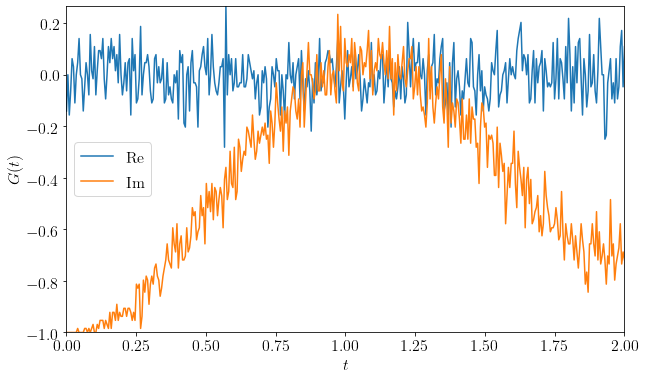

In [11]:
problem.run_green_circuits(site = 0,
                           shots_per_t = 2**6, # number of circuit measurements per t
                           backend = 'qasm_simulator')

# Compute Spectral Function $A(\omega)$

If we have previously set parameters that allow us to use the Discrete Fourier Transform directly, then we may use `QuGreen.convert_to_spectral_function(site = 0, method = 'fourier')`.

Here, we'll use compressed sensing, since we haven't sampled high time values. We have four methods:
* `EL1`, assumes that no error exists
* `L1` and `NL1`, which account for errors. These have the `l` and `eps` parameters, respectively.
* `SL0`, which applies smoothed L0 minimization, with parameter `eps`.

The `regularization` option takes the compressed sensing result and slightly corrects it to be a sum of Dirac deltas, as expected.

In [15]:
problem.convert_to_spectral_function(site = 0,
                                     method = 'L1',
                                     l = 0.002,
                                     symmetric = True, # If A(w)=A(-w), simplifies problem
                                     force_sym = True, # Forces A(w) to be symmetric
                                     regularization = True,
                                     show=False)

(Peak, frequency): [(0.21848487783694143, -3.0187345665972614), (0.26712871333233007, -0.5274643711698381), (0.26712871333233007, 0.5274643711698381), (0.21848471005251185, 3.018734564442701)]


And finally, we may plot the spectral function.

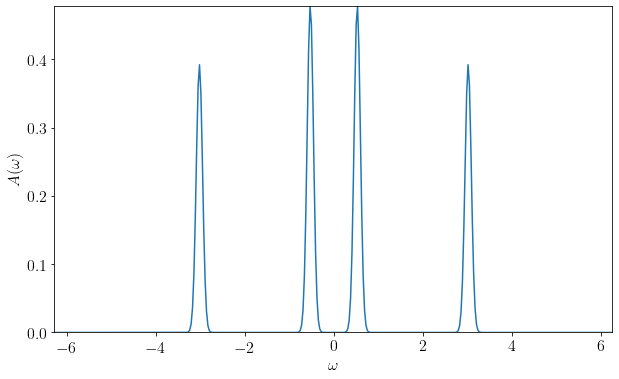

In [16]:
problem.plot_spectral_function(site = 0)

# Compare with Exact Results

Alternatively, we may also use the exact option, which does not compute a circuit at all, but finds the exact values for $G(t)$. In this case, we may bypass `QuGreen.set_time_evolution_circuit()` and `QuGreen.local_green()`, but we must still define the fourier parameters using `QuGreen.set_fourier_parameters()`.

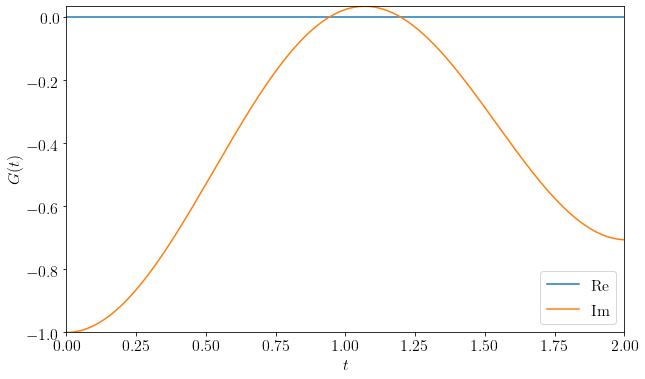

In [21]:
problem.get_green_time_exact(site = 0)
ReImPlot(problem.times[0], problem.green_time_exact[0], x=r'$t$', y=r'$G(t)$')

Taking these exact values we calculated for $G(t)$, we may do the same for the spectral function $A(\omega)$.

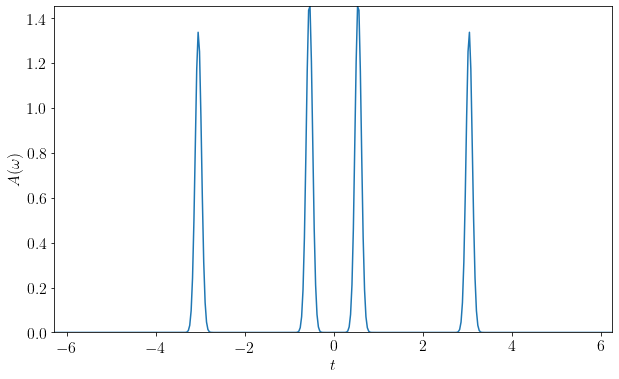

In [23]:
problem.get_spectral_function_exact(site = 0)
ReImPlot(problem.freqs[0], problem.spectral_function_exact[0], x=r'$t$', y=r'$A(\omega)$', method='noimag')

We see that the final experimental result for $A(\omega)$ was very similar to the exact one, despite the fact that the experimental results for $G(t)$ suffered heavily with stochastic noise.